<a href="https://colab.research.google.com/github/vedrocks15/Qiskit_Circuits/blob/master/DanceForms2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

***Classical - Quantum CNN*** \\
ResNet-18 is used as pre trained network \\
And variational quantum circuit is used before the prediction layer

In [ ]:
pip install pennylane

In [ ]:
import time
import os
import copy

# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, transforms

# Pennylane
import pennylane as qml
from pennylane import numpy as np

# Plotting
import matplotlib.pyplot as plt

# OpenMP: number of parallel threads.
os.environ["OMP_NUM_THREADS"] = "1"

qml.about()

Name: PennyLane
Version: 0.10.0
Summary: PennyLane is a Python quantum machine learning library by Xanadu Inc.
Home-page: https://github.com/XanaduAI/pennylane
Author: None
Author-email: None
License: Apache License 2.0
Location: /usr/local/lib/python3.6/dist-packages
Requires: toml, autograd, appdirs, semantic-version, networkx, scipy, numpy
Required-by: 
Platform info:           Linux-4.19.104+-x86_64-with-Ubuntu-18.04-bionic
Python version:          3.6.9
Numpy version:           1.18.5
Scipy version:           1.4.1
Installed devices:
- default.gaussian (PennyLane-0.10.0)
- default.qubit (PennyLane-0.10.0)
- default.qubit.tf (PennyLane-0.10.0)
- default.tensor (PennyLane-0.10.0)
- default.tensor.tf (PennyLane-0.10.0)


In [ ]:
n_qubits = 8               # Number of qubits
step = 0.0004               # Learning rate
batch_size = 4              # Number of samples for each training step
num_epochs = 10              # Number of training epochs
q_depth = 6                 # Depth of the quantum circuit (number of variational layers)
gamma_lr_scheduler = 0.1    # Learning rate reduction applied every 10 epochs.
q_delta = 0.01              # Initial spread of random quantum weights
rng_seed = 3                # Seed for random number generator
start_time = time.time()    # Start of the computation timer

In [ ]:
dev    = qml.device("default.qubit", wires=n_qubits)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
from google.colab import files
files.upload()

Saving 0664343c9a8f11ea.zip to 0664343c9a8f11ea (1).zip


In [ ]:
! ls
! mv 0664343c9a8f11ea (1).zip file.zip

'0664343c9a8f11ea (1).zip'   0664343c9a8f11ea.zip   sample_data
/bin/bash: -c: line 0: syntax error near unexpected token `('
/bin/bash: -c: line 0: ` mv 0664343c9a8f11ea (1).zip file.zip'


In [ ]:
! ls

'0664343c9a8f11ea (1).zip'   0664343c9a8f11ea.zip   sample_data


In [ ]:
! unzip '0664343c9a8f11ea (1).zip'

Archive:  0664343c9a8f11ea (1).zip
   creating: dataset/
   creating: dataset/test/
  inflating: dataset/test/508.jpg    
  inflating: dataset/test/246.jpg    
  inflating: dataset/test/473.jpg    
  inflating: dataset/test/485.jpg    
  inflating: dataset/test/128.jpg    
  inflating: dataset/test/410.jpg    
  inflating: dataset/test/465.jpg    
  inflating: dataset/test/196.jpg    
  inflating: dataset/test/340.jpg    
  inflating: dataset/test/467.jpg    
  inflating: dataset/test/306.jpg    
  inflating: dataset/test/171.jpg    
  inflating: dataset/test/323.jpg    
  inflating: dataset/test/332.jpg    
  inflating: dataset/test/330.jpg    
  inflating: dataset/test/170.jpg    
  inflating: dataset/test/479.jpg    
  inflating: dataset/test/9.jpg      
  inflating: dataset/test/283.jpg    
  inflating: dataset/test/114.jpg    
  inflating: dataset/test/507.jpg    
  inflating: dataset/test/183.jpg    
  inflating: dataset/test/200.jpg    
  inflating: dataset/test/457.jpg    
  in

In [ ]:
! ls
! pwd
! mkdir dataset/Train

'0664343c9a8f11ea (1).zip'   0664343c9a8f11ea.zip   dataset   sample_data
/content


In [ ]:
import pandas as pd
import os,shutil
df_train = pd.read_csv("dataset/train.csv")
df_test  = pd.read_csv("dataset/test.csv")
print("Train set :",len(df_train))
print("Test  set :",len(df_test))
new_train_path  = "dataset/Train/"
new_train_image = "dataset/train/"

# Storing train half based on the labels provided by the pandas file & directory name is label name
for _,r in df_train.groupby(df_train["target"]):
    tmp = new_train_path

    style = list(set(r["target"]))
    img   = list(r["Image"])

    tmp+=style[0]
    if os.path.exists(tmp):
        shutil.rmtree(tmp)
    os.mkdir(tmp)

    # copying all files
    for fname in img:
        src = os.path.join(new_train_image,fname)
        des = os.path.join(tmp,fname)
        shutil.copyfile(src,des)

Train set : 364
Test  set : 156


In [ ]:
! ls dataset/Train

bharatanatyam  kathakali  manipuri	odissi
kathak	       kuchipudi  mohiniyattam	sattriya


In [ ]:
data_transforms = {
    "Train": transforms.Compose(
        [
            # transforms.RandomResizedCrop(224),     # uncomment for data augmentation
            # transforms.RandomHorizontalFlip(),     # uncomment for data augmentation
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            # Normalize input channels using mean values and standard deviations of ImageNet.
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        ]
    ),
}

data_dir = "/content/dataset/"

image_datasets = {
    x if x == "Train" else "validation": datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x])
    for x in ["Train"]
}
dataset_sizes = {x: len(image_datasets[x]) for x in ["Train"]}
class_names = image_datasets["Train"].classes
print(class_names)

# Initialize dataloader
dataloaders = {
    x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True)
    for x in ["Train"]
}

# function to plot images
def imshow(inp, title=None):
    """Display image from tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    # Inverse of the initial normalization operation.
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)

['bharatanatyam', 'kathak', 'kathakali', 'kuchipudi', 'manipuri', 'mohiniyattam', 'odissi', 'sattriya']


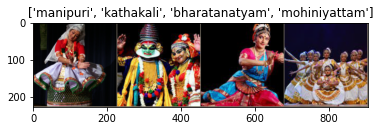

In [ ]:
# Get a batch of training data
inputs, classes = next(iter(dataloaders["Train"]))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

# In order to get reproducible results, we set a manual seed for the
# random number generator and re-initialize the dataloaders.

torch.manual_seed(rng_seed)
dataloaders = {
    x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True)
    for x in ["Train"]
}

Definition of a variational circuit

In [ ]:
def H_layer(nqubits):
    """Layer of single-qubit Hadamard gates.
    """
    for idx in range(nqubits):
        qml.Hadamard(wires=idx)


def RY_layer(w):
    """Layer of parametrized qubit rotations around the y axis.
    """
    for idx, element in enumerate(w):
        qml.RY(element, wires=idx)


def entangling_layer(nqubits):
    """Layer of CNOTs followed by another shifted layer of CNOT.
    """
    # In other words it should apply something like :
    # CNOT  CNOT  CNOT  CNOT...  CNOT
    #   CNOT  CNOT  CNOT...  CNOT
    for i in range(0, nqubits - 1, 2):  # Loop over even indices: i=0,2,...N-2
        qml.CNOT(wires=[i, i + 1])
    for i in range(1, nqubits - 1, 2):  # Loop over odd indices:  i=1,3,...N-3
        qml.CNOT(wires=[i, i + 1])

In [ ]:
@qml.qnode(dev, interface="torch")
def quantum_net(q_input_features, q_weights_flat):
    """
    The variational quantum circuit.
    """

    # Reshape weights
    q_weights = q_weights_flat.reshape(q_depth, n_qubits)

    # Start from state |+> , unbiased w.r.t. |0> and |1>
    H_layer(n_qubits)

    # Embed features in the quantum node
    RY_layer(q_input_features)

    # Sequence of trainable variational layers
    for k in range(q_depth):
        entangling_layer(n_qubits)
        RY_layer(q_weights[k])

    # Expectation values in the Z basis
    exp_vals = [qml.expval(qml.PauliZ(position)) for position in range(n_qubits)]
    return tuple(exp_vals)

In [ ]:
class DressedQuantumNet(nn.Module):
    """
    Torch module implementing the *dressed* quantum net.
    """

    def __init__(self):
        """
        Definition of the *dressed* layout.
        """

        super().__init__()
        self.pre_net = nn.Linear(512, n_qubits)
        self.q_params = nn.Parameter(q_delta * torch.randn(q_depth * n_qubits))
        self.post_net = nn.Linear(n_qubits, 8)

    def forward(self, input_features):
        """
        Defining how tensors are supposed to move through the *dressed* quantum
        net.
        """

        # obtain the input features for the quantum circuit
        # by reducing the feature dimension from 512 to 4
        pre_out = self.pre_net(input_features)
        q_in = torch.tanh(pre_out) * np.pi / 2.0

        # Apply the quantum circuit to each element of the batch and append to q_out
        q_out = torch.Tensor(0, n_qubits)
        q_out = q_out.to(device)
        for elem in q_in:
            q_out_elem = quantum_net(elem, self.q_params).float().unsqueeze(0)
            q_out = torch.cat((q_out, q_out_elem))

        # return the two-dimensional prediction from the postprocessing layer
        return self.post_net(q_out)

In [ ]:
model_hybrid = torchvision.models.resnet18(pretrained=True)

for param in model_hybrid.parameters():
    param.requires_grad = False


# Notice that model_hybrid.fc is the last layer of ResNet18
model_hybrid.fc = DressedQuantumNet()

# Use CUDA or CPU according to the "device" object.
model_hybrid = model_hybrid.to(device)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/checkpoints/resnet18-5c106cde.pth


In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer_hybrid = optim.Adam(model_hybrid.fc.parameters(), lr=step)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_hybrid, step_size=10, gamma=gamma_lr_scheduler)

In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    best_loss = 10000.0  # Large arbitrary number
    best_acc_train = 0.0
    best_loss_train = 10000.0  # Large arbitrary number
    print("Training started:")

    for epoch in range(num_epochs):
        print("Epoch : ",epoch)

        # Each epoch has a training and validation phase
        for phase in ["Train"]:
            if phase == "Train":
                # Set model to training mode
                model.train()
            else:
                # Set model to evaluate mode
                model.eval()
            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            n_batches = dataset_sizes[phase] // batch_size
            it = 0
            for inputs, labels in dataloaders[phase]:
                since_batch = time.time()
                batch_size_ = len(inputs)
                inputs = inputs.to(device)
                labels = labels.to(device)
                optimizer.zero_grad()

                # Track/compute gradient and make an optimization step only when training
                with torch.set_grad_enabled(phase == "Train"):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    if phase == "Train":
                        loss.backward()
                        optimizer.step()

                # Print iteration results
                running_loss += loss.item() * batch_size_
                batch_corrects = torch.sum(preds == labels.data).item()
                running_corrects += batch_corrects
                print("Phase: {} Epoch: {}/{} Iter: {}/{} Batch time: {:.4f}".format(
                        phase,
                        epoch + 1,
                        num_epochs,
                        it + 1,
                        n_batches + 1,
                        time.time() - since_batch,
                    ),
                    end="\r",
                    flush=True,
                )
                it += 1

            # Print epoch results
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects / dataset_sizes[phase]
            print("Phase: {} Epoch: {}/{} Loss: {:.4f} Acc: {:.4f}        ".format(
                    "train" if phase == "Train" else "validation  ",
                    epoch + 1,
                    num_epochs,
                    epoch_loss,
                    epoch_acc,
                )
            )

            # Check if this is the best model wrt previous epochs
            if phase == "Train" and epoch_acc > best_acc_train:
                best_acc_train = epoch_acc
            if phase == "Train" and epoch_loss < best_loss_train:
                best_loss_train = epoch_loss

            # Update learning rate
            if phase == "Train":
                scheduler.step()

    # Print final results
    model.load_state_dict(best_model_wts)
    time_elapsed = time.time() - since
    print("Training completed in {:.0f}m {:.0f}s".format(time_elapsed // 60, time_elapsed % 60))
    print("Best test loss: {:.4f} | Best test accuracy: {:.4f}".format(best_loss_train, best_acc_train))
    return model

In [ ]:
model_hybrid = train_model(
    model_hybrid, criterion, optimizer_hybrid, exp_lr_scheduler, num_epochs=num_epochs
)


Training started:
Epoch :  0
Phase: train Epoch: 1/1 Loss: 2.0729 Acc: 0.1731        
Training completed in 7m 10s
Best test loss: 2.0729 | Best test accuracy: 0.1731


In [ ]:
def visualize_model(model, num_images=6, fig_name="Predictions"):
    images_so_far = 0
    _fig = plt.figure(fig_name)
    model.eval()
    with torch.no_grad():
        for _i, (inputs, labels) in enumerate(dataloaders["Train"]):
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images // 2, 2, images_so_far)
                ax.axis("off")
                ax.set_title("[{}]".format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])
                if images_so_far == num_images:
                    return


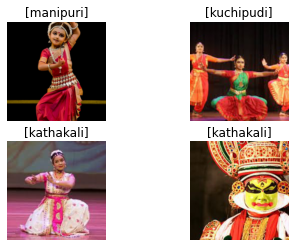

In [ ]:
visualize_model(model_hybrid, num_images=batch_size)
plt.show()